# **Import Libraries**

In [1]:
# MNE 
import mne

# Utility
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
np.random.seed(42)

In [2]:
import sys

sys.path.append('../')

from module.models import FFT_CNNModel, CNNModel
from module.utilities import read_xdf, epoching

# **Load Data**

In [3]:
annotations_des = {
    '1': 'Left cue start',
    '2': 'Left stimuli start',
    '3': 'Left blank start',
    '4': 'Right cue start',
    '5': 'Right stimuli start',
    '6': 'Right blank start',
}

In [4]:
def get_epoch(filenames):
    # Define temporal variables
    X, F, t, y = [],[],[],[]
    for filename in filenames:
        ##--------Get First 5 second--------##
        raw = read_xdf(filename, show_plot=False, show_psd=False, verbose=False)
        epochs = epoching(raw, show_psd=False,
            show_eeg=False,  # set True if wanna see preview of all epoch
            tmax=5)         # tmax=5 means set epoch duration 5 second
        # Pick only event 2: Left stimuli, 5: Right stimuli
        epochs = epochs['2','5']
        X.append((  epochs.get_data())[:,:,:1250]) # select only first 1250 frames(approx 5 second)
        F.append(   epochs.compute_psd(method='welch', fmax=30).get_data())
        t.append((  epochs.times)[:1250])                # select only first 1250 frames(approx 5 second)
        y.append(   epochs.events[:, -1])
        ##--------Get Last 5 second--------##
        epochs = epoching(raw, show_psd=False,
            show_eeg=False,  # set True if wanna see preview of all epoch
            baseline=(5,10),
            tmin=5,
            tmax=10)         # tmax=5 means set epoch duration 5 second
        # Pick only event 2: Left stimuli, 5: Right stimuli
        epochs = epochs['2','5']
        X.append((  epochs.get_data())[:,:,:1250]) # select only first 1250 frames(approx 5 second)
        F.append(   epochs.compute_psd(method='welch', fmax=30).get_data())
        t.append((  epochs.times)[:1250])                # select only first 1250 frames(approx 5 second)
        y.append(   epochs.events[:, -1])
    # Concatenate all data
    X = np.concatenate(X)
    F = np.concatenate(F)
    t = np.concatenate(t)
    y = np.concatenate(y)
    return X, F, t, y

## **Load Left Data**

In [5]:
filenames = {'../data/18_5_2023/Pipo_6Hz.xdf', '../data/28_5_2023/Pipo_6Hz.xdf'}

Xl, Fl, tl, yl = get_epoch(filenames)

Creating RawArray with float64 data, n_channels=8, n_times=51160
    Range : 0 ... 51159 =      0.000 ...   204.541 secs
Ready.
Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1252 original time points ...
0 bad epochs dropped
Effective window size : 5.006 (s)
Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
1 bad epochs dropped
Effective window size : 5.002 (s)


In [6]:
# Map label to 0
yl = np.where(yl==2, 0, yl)
yl = np.where(yl==5, 0, yl)
yl

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## **Load Right Data**

In [7]:
filenames = {'../data/18_5_2023/Pipo_10Hz.xdf', '../data/28_5_2023/Pipo_10Hz.xdf'}

Xr, Fr, tr, yr = get_epoch(filenames)

Creating RawArray with float64 data, n_channels=8, n_times=52650
    Range : 0 ... 52649 =      0.000 ...   210.499 secs
Ready.
Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1252 original time points ...
0 bad epochs dropped
Effective window size : 5.006 (s)
Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
Effective window size : 5.002 (s)


In [8]:
# Map label to 0
yr = np.where(yr==2, 1, yr)
yr = np.where(yr==5, 1, yr)
yr

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## **Load Free-State Data**

In [9]:
filenames = {'../data/18_5_2023/Pipo_unksignal_1.xdf', '../data/28_5_2023/Pipo_unksignal_1.xdf', '../data/28_5_2023/Pipo_unksignal_2.xdf'}

Xfs, Ffs, tfs, yfs = get_epoch(filenames)

Creating RawArray with float64 data, n_channels=8, n_times=49780
    Range : 0 ... 49779 =      0.000 ...   199.048 secs
Ready.
Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
1 bad epochs dropped
Effective window size : 5.002 (s)
Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1252 original time points ...
1 bad epochs dropped
Effective window size : 5.006 (s)


In [10]:
# Map label of y to 2
yfs[yfs==5] = 2
yfs

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [11]:
Xfs.shape, Ffs.shape, tfs.shape, yfs.shape

((32, 3, 1250), (32, 3, 151), (2500,), (32,))

## **Load Mixed Data**

In [12]:
filenames = {'../data/18_5_2023/Pipo_normal_1.xdf','../data/18_5_2023/Pipo_normal_1.xdf'}

Xm, Fm, tm, ym = get_epoch(filenames)

Creating RawArray with float64 data, n_channels=8, n_times=50660
    Range : 0 ... 50659 =      0.000 ...   202.544 secs
Ready.
Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1252 original time points ...
1 bad epochs dropped
Effective window size : 5.006 (s)
Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
1 bad epochs dropped
Effective window size : 5.002 (s)
Creating RawArray with float64 data, n_channels=8, n_times=50270
    Range : 0 ... 50269 =      0.000 ...   201.005 secs
Ready.
Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Not setting metadata
48 matching events found
Applying bas

In [13]:
# Map label of 2 to 0 and 5 to 1
ym[ym==2] = 0
ym[ym==5] = 1
ym

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0])

## **Concatenate Data**

In [14]:
X = np.concatenate([Xl, Xr, Xfs, Xm])
F = np.concatenate([Fl, Fr, Ffs, Fm])
t = np.concatenate([tl, tr, tfs, tm])
y = np.concatenate([yl, yr, yfs, ym])

X.shape, F.shape, t.shape, y.shape

((160, 3, 1250), (160, 3, 151), (12500,), (160,))

# **Preprocessing**

In [15]:
enc = OneHotEncoder()
Y = enc.fit_transform(y.reshape(-1, 1)).toarray()

In [16]:
X.shape, F.shape, t.shape, Y.shape

((160, 3, 1250), (160, 3, 151), (12500,), (160, 3))

## **Training pipeline**

### Train Test Split

In [17]:
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(X, Y, test_size=0.2, random_state=1)

# **Model Pipeline**

## **Load Model**

In [18]:
CNN = CNNModel(input_channels=3, input_size=1250)
CNN.model.summary()

Model: "CNNModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3, 1250)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            480128    
                                                                 
 batch_norm_layer1 (BatchNor  (None, 1, 128)           512       
 malization)                                                     
                                                                 
 maxpool_layer1 (MaxPooling1  (None, 1, 128)           0         
 D)                                                              
                                                                 
 dropout_layer1 (Dropout)    (None, 1, 128)            0         
                                                                 
 dense_layer1 (Dense)        (None, 1, 64)             825

## **Train Model**

In [19]:
CNN.model_train(X_train_CNN, y_train_CNN)

Epoch 1/5
32/32 [==============================] - 3s 7ms/step - loss: 0.8955 - accuracy: 0.5625
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 0.7738 - accuracy: 0.6953
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 0.5766 - accuracy: 0.7344
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 0.4911 - accuracy: 0.8125
Epoch 5/5
32/32 [==============================] - 0s 7ms/step - loss: 0.4294 - accuracy: 0.8125


## **Evaluate the model**

In [20]:
prop, predictions = CNN.model_predict_classes(X_test_CNN)
predictions

1/1 [==============================] - 0s 105ms/step


array([0, 1, 0, 2, 2, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 1,
       1, 0, 2, 0, 0, 2, 0, 2, 1, 0], dtype=int64)

In [21]:
# # Classification report
print(classification_report(np.argmax(y_test_CNN, axis=1), predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.83      0.91      0.87        11
           2       0.88      0.78      0.82         9

    accuracy                           0.91        32
   macro avg       0.90      0.90      0.90        32
weighted avg       0.91      0.91      0.91        32



# **FFT_CNN**

In [23]:
FFT_CNN = FFT_CNNModel(input_channels=3, input_size=626)
FFT_CNN.model.summary()

Loaded pretrained FFT_CNNModel.h5
Model: "FFT_CNNModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3, 626)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            240512    
                                                                 
 batch_norm_layer1 (BatchNor  (None, 1, 128)           512       
 malization)                                                     
                                                                 
 maxpool_layer1 (MaxPooling1  (None, 1, 128)           0         
 D)                                                              
                                                                 
 dropout_layer1 (Dropout)    (None, 1, 128)            0         
                                                                 
 dense_layer1 (Dense

In [24]:
FFT_CNN.model_train(X_train_CNN, y_train_CNN)

Epoch 1/10
32/32 [==============================] - 1s 7ms/step - loss: 0.1669 - accuracy: 0.9531
Epoch 2/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1241 - accuracy: 0.9375
Epoch 3/10
32/32 [==============================] - 0s 7ms/step - loss: 0.2053 - accuracy: 0.9219
Epoch 4/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0776 - accuracy: 0.9844
Epoch 5/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1987 - accuracy: 0.9297
Epoch 6/10
32/32 [==============================] - 0s 7ms/step - loss: 0.1098 - accuracy: 0.9609
Epoch 7/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1850 - accuracy: 0.9297
Epoch 8/10
32/32 [==============================] - 0s 9ms/step - loss: 0.0963 - accuracy: 0.9688
Epoch 9/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0936 - accuracy: 0.9609
Epoch 10/10
32/32 [==============================] - 0s 9ms/step - loss: 0.0583 - accuracy: 0.9766


In [25]:
prop , predictions = FFT_CNN.model_predict_classes(X_test_CNN)

1/1 [==============================] - 0s 78ms/step


In [26]:
print(classification_report(np.argmax(y_test_CNN, axis=1), predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         9

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



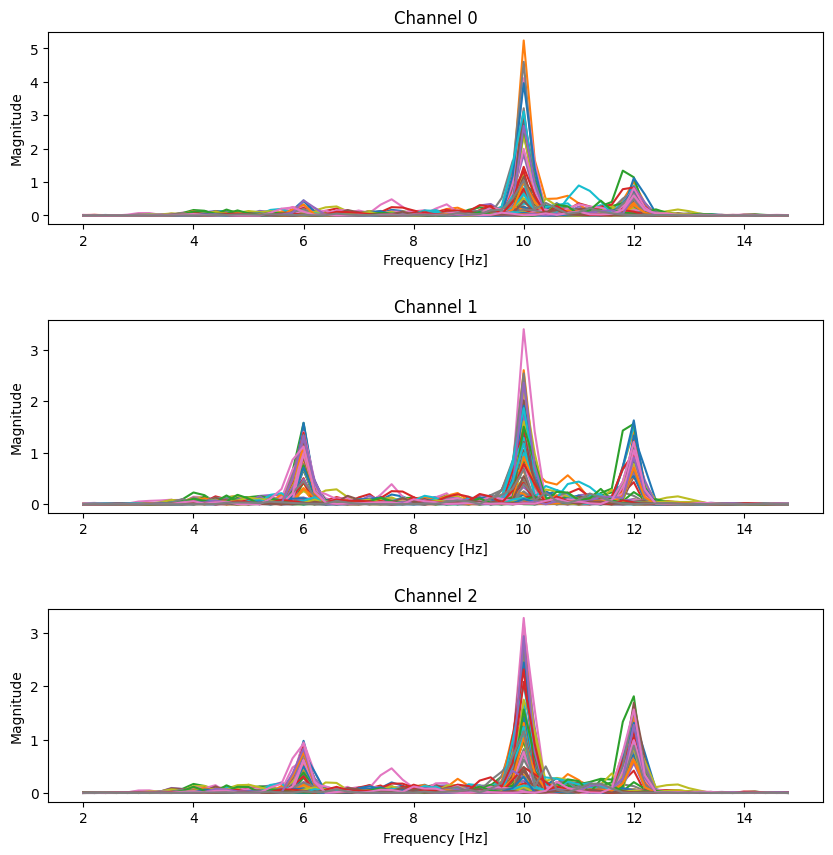

In [27]:
FFT_CNN.fft_plot(X_train_CNN)